#### Reinforcement Learning with BlueSky
In this Jupyter Notebook we will look at how to use Bluesky for a simple Reinforcement Learning task.

Lets start by importing the relevant modules:

In [1]:
import numpy as np

import bluesky as bs
from bluesky.simulation import ScreenIO

#The Soft Actor Critic Class used for the Deep Reinforcement Learning part of this notebook
from SAC.sac_agent import SAC

Using Python-based geo functions


We create a dummy class that acts as the screen of BlueSky. Since we don't want to actually load the screen from BlueSky here, a simple and small class is used instead to avoid errors when something within BlueSky is calling the echo function.

In [2]:
class ScreenDummy(ScreenIO):
    """
    Dummy class for the screen. Inherits from ScreenIO to make sure all the
    necessary methods are there. This class is there to reimplement the echo
    method so that console messages are printed.
    """
    def echo(self, text='', flags=0):
        """Just print echo messages"""
        print("BlueSky console:", text)

The first step to take is to initialise bluesky (here imported as bs) as a disconnected, single simulation. Next we replace the screen object with our derived variant so that bluesky console messages are printed.

In [3]:

# initialize bluesky as non-networked simulation node

bs.init(mode='sim', detached=True)

# initialize dummy screen
bs.scr = ScreenDummy()

Reading config from C:\Users\Jan\bluesky\settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: C:/Users/Jan/bluesky/data/cache\py3\navdata.p
Failed to load OpenAP performance model
Failed to load BADA performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


In [37]:
def reset_env():
    bs.traf.delete(0)
    bs.traf.cre('KL001',actype="A320",acalt=3000,acspd=150)
    return get_state()

In [50]:
def do_action(action):
    action = action * 2500
    acid = bs.traf.id[0]
    if -250<action<250:
        bs.stack.stack(f'ALT {acid},{bs.traf.alt[0]},{250}')
    if action > 0:
        bs.stack.stack(f'ALT {acid},45000,{action}')
    if action < 0:
        bs.stack.stack(f'ALT {acid},0,{-action}')

In [21]:
def get_state():
    alt = (bs.traf.alt[0]-1500)/3000
    vs = bs.traf.vs[0]
    dis = (200 - bs.tools.geo.kwikdist(52,4,bs.traf.lat[0],bs.traf.lon[0])*1.852-100)/200

    state = [alt,vs,dis]
    return state

In [32]:
def get_reward(state):
    alt = (state[0]*3000)+1500
    dis = (state[2]*200)+100
    if dis > 0 and alt> 0:
        return abs(3000-alt)*-5/3000, 0
    elif alt <= 0:
        return -10, 1
    elif dis <= 0:
        return abs(100-alt)*-20/3000, 1
        

In [8]:
def get_update(state):
    reward, done = get_reward(state)
    state_ = get_state()
    return state_,reward,done

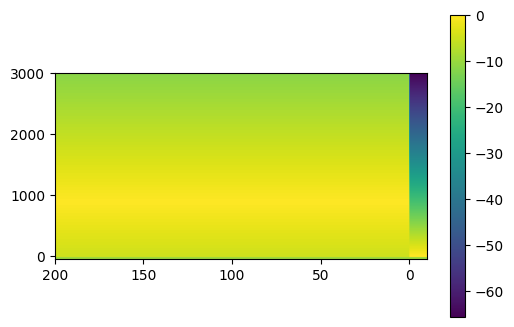

In [31]:
#heatmap of the reward function
import matplotlib.pyplot as plt

xarray = np.flip(np.arange(-10,210,1))
yarray = np.flip(np.arange(-50,10000,50))

reward_map = np.zeros((len(yarray),len(xarray)))

for i in range(len(xarray)):
    for j in range(len(yarray)):
        state = [yarray[j],0,xarray[i]]
        reward_map[j,i], _ = get_reward(state)
        
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
figure = ax.imshow(reward_map, extent=[200,-10,-50,3000])

cbar = plt.colorbar(figure)
im = ax.get_images()
extent =  im[0].get_extent()
ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/2)

plt.show()

In [49]:
_ = reset_env()
bs.stack.stack('DT 1;FF')

steps = 5
actionlist = np.ones(8)*0 #[-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500,-2500]
print(actionlist)
alt = np.zeros(len(actionlist))
vs = np.zeros(len(actionlist))
j = 0
print(bs.traf.gs[0])
print(bs.sim.simt)

for action in actionlist:
    
    for i in range(30):
        do_action(action)
        bs.sim.step()
    
    alt[j] = bs.traf.alt[0]
    vs[j] = bs.traf.vs[0]
    j+=1

state = get_state()
print(state)
print(bs.traf.gs[0])
print(alt)
#print(vs)
#print(bs.sim.simt)

[0. 0. 0. 0. 0. 0. 0. 0.]
172.3931462807866
1989818.0
BlueSky console: Base dt set to 1.0
performance dt is unchanged.
asas dt is unchanged.
AREA dt is unchanged.
DATAFEED.update dt is unchanged.
[-0.10451999999999999, -7.62, 0.301598626549341]
158.41790928811142
[2786.64 2558.04 2329.44 2100.84 1872.24 1643.64 1415.04 1186.44]


In [52]:
bs.stack.stack('DT 1;FF')

N_episodes = 100
action_frequency = 30
Rewards = np.zeros(N_episodes)
agent = SAC(1,3)

for episode in range(N_episodes):
    #initialise episode
    alt = np.array([])
    dist = np.array([])
    done = 0
    state = reset_env()
    total_reward = 0
    while not done:
        action = agent.step(state)
        do_action(action[0][0])
        for i in range(action_frequency):
            bs.sim.step()
        state_, reward, done = get_update(state)
        agent.store_transition(state,state_,reward,action[0][0],done)
        agent.train()
        state = state_
        total_reward += reward

        alt = np.append(alt,(state[0]*3000)+1500)
        dist = np.append(dist,(state[2]*200)+100)
    Rewards[episode] = total_reward
    if episode % 10 == 0:
        print(np.mean(Rewards[0:episode]))

DEVICE USED <torch.cuda.device object at 0x000001EE1856A470> Quadro P2000
BlueSky console: Base dt set to 1.0
performance dt is unchanged.
asas dt is unchanged.
AREA dt is unchanged.
DATAFEED.update dt is unchanged.
nan
-62.584224841166666
-58.37572346116666
-56.10730240444444
-52.713354992083325
-51.63209004749999
-49.257904899194436
-47.775531565523806
-46.244465970250005
-45.47061152237037


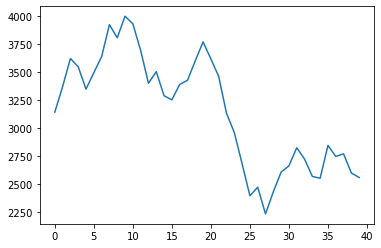

In [53]:
import matplotlib.pyplot as plt
plt.plot(alt)